In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS
from scipy.optimize import curve_fit

code_id = "0860 - Decoding Retrieval With GNB"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Decoded Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results is already existed!


# Decoding with GNB Rather

In [2]:

def gnb_decoder(trace, n: int):
    """
    Decode the trace using the GNB decoder.
    """
    if exists(join(saved_dir, f" {int(trace['MiceID'])}_{n}.pkl")):
        with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'rb') as f:
            (
                pos_traj,
                nodes_traj,
                speed_traj,
                smoothed_speed_traj,
                cumlen_traj,
                time_traj,
                lap_traj,
                route_traj,
                perfect_traj,
                raw_traj,
                
                loss_traj,
                smoothed_loss_traj,
                decoded_nodes_traj,
                decoded_nodes_traj_shuf,
                retriv_state_traj
            ) = pickle.load(f)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
    else:
        beg, end = LapSplit(trace, trace['paradigm'])
        beg_t, end_t = trace['lap beg time'], trace['lap end time']
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
        
        raw_traces = trace['RawTraces']
        ms_time = trace['ms_time']
        spike_nodes = trace['spike_nodes_original']
        
        raw_traj = []
        pos_traj = []
        nodes_traj = []
        cumlen_traj = []
        time_traj = []
        lap_traj = []
        route_traj = []
        speed_traj = []
        perfect_traj = []
        
        print("Initialization.")
        for i in tqdm(range(len(beg))):
            spike_idx = np.where(
                (ms_time >= beg_t[i]) & (ms_time <= end_t[i]) &
                (np.isnan(trace['spike_nodes_original']) == False)
            )[0]
            ms_t = (ms_time[spike_idx]-ms_time[spike_idx[0]])/1000

            displacement = np.diff(trace['correct_pos'][beg[i]:end[i], :]/10, axis=0)
            dt = np.diff(trace['correct_time'][beg[i]:end[i]])
            speed = np.sqrt(np.sum(displacement**2, axis=1)) * 1000 / dt
            t = (trace['correct_time'][beg[i]:end[i]] - trace['correct_time'][beg[i]])/1000
            cumlen = np.cumsum(np.sqrt(np.sum(displacement**2, axis=1)))
            
            behav_to_ms_idx = _coordinate_recording_time(ms_t.astype(np.float64), t.astype(np.float64))

            pos_traj.append(trace['correct_pos'][beg[i]:end[i], :][behav_to_ms_idx, :].T/10)
            nodes_traj.append(trace['correct_nodes'][beg[i]:end[i]][behav_to_ms_idx])
            speed_traj.append(np.concatenate(([0], speed))[behav_to_ms_idx])
            cumlen_traj.append(np.concatenate(([0], cumlen))[behav_to_ms_idx])
            time_traj.append(ms_t)
            lap_traj.append(np.ones_like(ms_t) * i)
            route_traj.append(np.ones_like(ms_t) * routes[i])
            perfect_traj.append(np.ones_like(ms_t) * trace['is_perfect'][i])
            raw_traj.append(raw_traces[:, spike_idx])

        pos_traj = np.concatenate(pos_traj, axis=1).astype(np.float64)
        nodes_traj = np.concatenate(nodes_traj).astype(np.int64)
        speed_traj = np.concatenate(speed_traj).astype(np.float64)
        cumlen_traj = np.concatenate(cumlen_traj).astype(np.float64)
        time_traj = np.concatenate(time_traj).astype(np.float64)
        lap_traj = np.concatenate(lap_traj).astype(np.int64)

        route_traj = np.concatenate(route_traj).astype(np.int64)
        perfect_traj = np.concatenate(perfect_traj).astype(np.int64)
        raw_traj = np.concatenate(raw_traj, axis=1).astype(np.float64)
        Spikes = np.where(raw_traj - np.std(raw_traj, axis=1)[:, np.newaxis] * 3 >= 0, 1, 0)
        
        train_idx = np.where(route_traj == 0)[0]
        test_idx = np.setdiff1d(np.arange(nodes_traj.shape[0]), train_idx)
        
        D = GetDMatrices(1, 48)
        
        print("Decoding.")
        model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
        model.fit(Spikes[:, train_idx], nodes_traj[train_idx])
        y_pred = model.predict(Spikes_test=Spikes, MazeID_test=nodes_traj)
        y_test = nodes_traj

        print("Decoding Shuffled Spikes.")
        loss_traj = D[(y_pred-1, y_test-1)]
        decoded_nodes_traj = y_pred
        p0 = np.where(Spikes == 0)[0].shape[0]
        Spike_train_shuf = cp.deepcopy(Spikes)
        for i in range(Spike_train_shuf.shape[0]):
            Spike_train_shuf[i, :] = np.random.permutation(Spike_train_shuf[i, :])
        y_pred_shuf = model.predict(Spikes_test=Spike_train_shuf, MazeID_test=nodes_traj)
        decoded_nodes_traj_shuf = y_pred_shuf
        
        smoothed_loss_traj = np.zeros_like(loss_traj, dtype=np.float64)
        smoothed_speed_traj = np.zeros_like(speed_traj, dtype=np.float64)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
        for i in range(len(beg)):
            smoothed_loss_traj[beg[i]:end[i]] = np.convolve(loss_traj[beg[i]:end[i]], np.ones(10)/10, mode='same')
            smoothed_speed_traj[beg[i]:end[i]] = np.convolve(speed_traj[beg[i]:end[i]], np.ones(3)/3, mode='same')
            
    print("Identify Retrieval Moment.")
    retriv_state_traj = np.zeros_like(loss_traj, dtype=np.int64)
    retriv_state_traj[smoothed_loss_traj < 10] = 1
    for i in range(len(beg)):
        if route_traj[beg[i]] == 0:
            retriv_state_traj[beg[i]:end[i]] = 1
            continue

        _converge_idx = np.where(smoothed_loss_traj[beg[i]:end[i]] <= 10)[0]

        if _converge_idx.shape[0] < 1:
            continue
        
        retriv_state_traj[beg[i]:beg[i] + _converge_idx[0]] = 0
        retriv_state_traj[beg[i] + _converge_idx[0]:end[i]] = 2
        retriv_state_traj[beg[i] + _converge_idx] = 1
    
    with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'wb') as f:
        pickle.dump((
            pos_traj,
            nodes_traj,
            speed_traj,
            smoothed_speed_traj,
            cumlen_traj,
            time_traj,
            lap_traj,
            route_traj,
            perfect_traj,
            raw_traj,
            
            loss_traj,
            smoothed_loss_traj,
            decoded_nodes_traj,
            decoded_nodes_traj_shuf,
            retriv_state_traj
        ), f)
    
    return (
        pos_traj,
        nodes_traj,
        speed_traj,
        smoothed_speed_traj,
        cumlen_traj,
        time_traj,
        lap_traj,
        route_traj,
        perfect_traj,
        raw_traj,
        
        loss_traj,
        smoothed_loss_traj,
        decoded_nodes_traj,
        decoded_nodes_traj_shuf,
        retriv_state_traj
    )



# Example Laps

(248448,) (248448,)
88.5


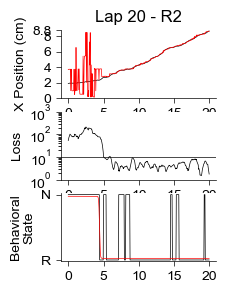

81.5


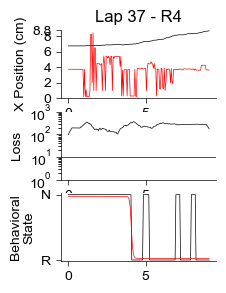

In [3]:
mouse = 10232
with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
    res = pickle.load(f)
    
def logistic_1_to_0(t, t0, k=1.0):
    # optional clipping for numerical safety if T is large
    z = k * (t - t0)
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(z))

def find_best_t0_manual(binary_seq, k=1.0):
    """
    binary_seq: 1D array-like, values in {0, 1}
                1 = non-retrieved, 0 = retrieved
    k: logistic steepness (default = 1)
    
    Returns:
        best_t0: t0 with minimum SSE
        candidate_t0s: array of all tested t0 values
        sse_values: SSE for each candidate t0
    """
    binary_seq = np.asarray(binary_seq, dtype=float)
    T = len(binary_seq)
    t = np.arange(-10, T+10)
    binary_seq_temp = np.concatenate([
        np.ones(10),
        binary_seq,
        np.ones(10)
    ]).astype(np.float64)
    binary_seq_temp = np.convolve(binary_seq_temp, np.ones(5)/5, mode='same')

    # t0 candidates: -0.5, 0.5, ..., T-1.5, T-0.5
    candidate_t0s = np.arange(-0.5, T + 0.5, 1.0)

    sse_values = []
    for t0 in candidate_t0s:
        pred = logistic_1_to_0(t, t0, k=k)
        sse = np.sum((binary_seq_temp - pred) ** 2)
        sse_values.append(sse)

    sse_values = np.array(sse_values)
    best_idx = np.argmin(sse_values)
    best_t0 = candidate_t0s[best_idx]

    return best_t0, candidate_t0s, sse_values
    
pos_traj = res['raw_pos_traj']
nodes_traj = res['raw_nodes_traj']
speed_traj = res['raw_speed_traj']
cumlen_traj = res['raw_cumlen_traj']
time_traj = res['raw_time_traj']
lap_traj = res['raw_lap_traj']
route_traj = res['raw_route_traj']
perfect_traj = res['raw_perfect_traj']
raw_traj = res['raw_traj']
decoded_nodes_traj = res['raw_decoded_nodes_traj']
smoothed_loss_traj = res['raw_smoothed_loss_traj']
retriv_state_traj = res['raw_retriv_state_traj']
hidden_state_traj = res['raw_hidden_state_traj']
session_traj = res['raw_session_traj']
print(hidden_state_traj.shape, route_traj.shape)

D = GetDMatrices(1, 48)
pred_x = D[decoded_nodes_traj-1, 0] / np.max(D) * 111
test_x = D[nodes_traj-1, 0] / np.max(D) * 111

beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]))

for i in range(len(beg)):
    if session_traj[beg[i]] != 0:
        continue
    
    if route_traj[beg[i]] == 0:
        continue
    
    if i not in [19, 36]:
        continue
    
    fig, axes = plt.subplots(3, 1, figsize=(2, 3))
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax0.plot(time_traj[beg[i]:end[i]], test_x[beg[i]:end[i]], color='black', lw=0.5)
    ax0.plot(time_traj[beg[i]:end[i]], pred_x[beg[i]:end[i]], color='red', lw=0.5)
    ax0.set_ylabel('X Position (cm)')
    ax0.set_title(f"Lap {i+1} - R{route_traj[beg[i]]+1}")
    ax0.set_ylim(0, 110)
    ax0.set_yticks([0, 25, 50, 75, 100, 110], (0, 2, 4, 6, 8, 8.8))
    xlim = ax0.get_xlim()
    ax0.set_xticks(np.linspace(0, 100, 21))
    ax0.set_xlim(xlim[0], xlim[1])
    
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.plot(time_traj[beg[i]:end[i]], smoothed_loss_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax1.set_ylim(1, 1000)
    ax1.semilogy()
    ax1.axhline(10, color='k', lw=0.5)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Time (s)')
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax1.set_xticks(np.linspace(0, 100, 21))
    ax1.set_xlim(xlim[0], xlim[1])
    
    ax2 = Clear_Axes(axes[2], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    t0 = find_best_t0_manual(hidden_state_traj[beg[i]:end[i]])[0]
    print(t0)
    y = logistic_1_to_0(np.arange(len(hidden_state_traj[beg[i]:end[i]])), t0)
    ax2.plot(time_traj[beg[i]:end[i]], hidden_state_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax2.plot(time_traj[beg[i]:end[i]], y*0.95+0.025, color='red', lw=0.5)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_yticks(np.linspace(0, 1, 2), ['R', 'N'])
    ax2.set_ylabel('Behavioral\nState')
    ax2.set_xticks(np.linspace(0, 100, 21))
    ax2.set_xlim(xlim[0], xlim[1])
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.png"), dpi=600)
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.svg"), dpi=600)
    plt.show()

# Spatial Distribution of Behavioral Retrieval

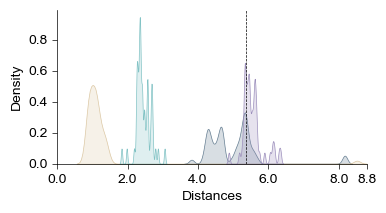

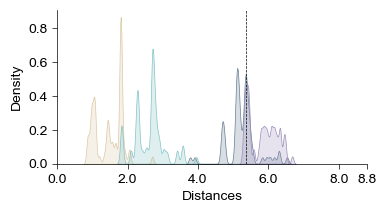

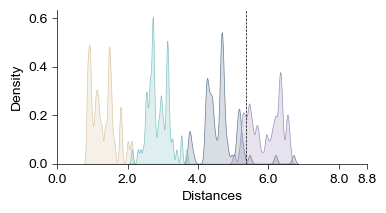

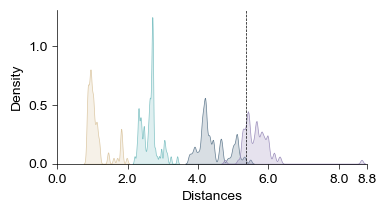

In [4]:
if exists(join(figdata, f"{code_id} [Retrieval Distances].pkl")) == False:
    RetrivDis = {
        "MiceID": [],
        "Session": [],
        "Lap": [],
        "Route": [],
        "Distances": [],
        "Time": [],
        "Type": [],
    }
    D = GetDMatrices(1, 48)
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
    
        hidden_state_traj = res['raw_hidden_state_traj']
        session_traj = res['raw_session_traj']
        lap_traj = res['raw_lap_traj']
        route_traj = res['raw_route_traj']
        pos_traj = res['raw_pos_traj']
        nodes_traj = res['raw_nodes_traj']
        time_traj = res['raw_time_traj']
        smoothed_loss_traj = res['raw_smoothed_loss_traj']

        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse}:")
        lap_count = 0
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if rt in [0, 3, 6]:
                continue
            transition_idx = int(find_best_t0_manual(hidden_state_traj[beg[i]:end[i]])[0])+1
            dist = D[nodes_traj[beg[i] + transition_idx]-1, 0]
                
            RetrivDis["MiceID"].append(mouse)
            RetrivDis["Session"].append(session_traj[beg[i]])
            RetrivDis["Lap"].append(lap_count)
            RetrivDis["Route"].append(rt)
            RetrivDis["Distances"].append(dist)
            RetrivDis["Type"].append("Behavioral")
            RetrivDis["Time"].append(time_traj[beg[i] + transition_idx])
                
            # Now for the neural retrieval
            neural_retriv_idx = np.where(smoothed_loss_traj[beg[i]:end[i]] <= 10)[0]
            if neural_retriv_idx.shape[0] < 1:
                neural_retriv_idx = end[i] - beg[i] - 1
            else:
                neural_retriv_idx = neural_retriv_idx[0]
            
            dist_n = D[nodes_traj[beg[i] + neural_retriv_idx]-1, 0]
                
            RetrivDis["MiceID"].append(mouse)
            RetrivDis["Session"].append(session_traj[beg[i]])
            RetrivDis["Lap"].append(lap_count)
            RetrivDis["Route"].append(rt)
            RetrivDis["Distances"].append(dist_n)
            RetrivDis["Type"].append("Neural")
            RetrivDis["Time"].append(time_traj[beg[i] + neural_retriv_idx])
                
            lap_count += 1
    
    for key in RetrivDis.keys():
        if key in ["MiceID", "Session", "Lap", "Route"]:
            RetrivDis[key] = np.array(RetrivDis[key], dtype=np.int64)
        elif key == "Distances":
            RetrivDis[key] = np.array(RetrivDis[key], dtype=np.float64)
        else:
            RetrivDis[key] = np.array(RetrivDis[key])
        
        
    with open(join(figdata, f"{code_id} [Retrieval Distances].pkl"), 'wb') as f:
        pickle.dump(RetrivDis, f)
        
    RetrivDisData = pd.DataFrame(RetrivDis)
    RetrivDisData.to_excel(join(figdata, f"{code_id} [Retrieval Distances].xlsx"), index=False)
    print(len(RetrivDisData))
else:
    with open(join(figdata, f"{code_id} [Retrieval Distances].pkl"), 'rb') as f:
        RetrivDis = pickle.load(f)


RetrivDis['Distances'] = RetrivDis['Distances'] / np.max(GetDMatrices(1, 48) + 1e-8) * 8.8
"""D = GetDMatrices(1, 48)
save_dir = join(loc, "Retrieval Distances")
mkdir(save_dir)
for mouse in [10212, 10224, 10227, 10232]:
    
    nt_idx = np.where((RetrivDis['Type'] == 'Neural') & (RetrivDis['MiceID'] == mouse))[0]
    bt_idx = np.where((RetrivDis['Type'] == 'Behavioral') & (RetrivDis['MiceID'] == mouse))[0]
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(2, 7), gridspec_kw={'height_ratios':[1.5, 5.5]})
    ax0 = Clear_Axes(ax[0], close_spines=['top', 'right', 'bottom'], ifxticks=False, ifyticks=True)
    subdata = SubDict(RetrivDis, RetrivDis.keys(), np.where((RetrivDis['Type'] == 'Neural')&(RetrivDis['MiceID'] == mouse))[0])
    sns.histplot(
        x="Distances",
        bins=50,
        hue="Route",
        palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
        line_kws={'linewidth': 0.5},
        stat="density",
        element="step",
        linewidth=0.5,
        data=subdata,
        ax=ax0,
        legend=False
    )
    for dp in DP_DSPs[1][0]:
        sonbins = np.array(Father2SonGraph[dp])
        dp_dists = D[sonbins-1, 0] / np.max(D+1e-8) * 8.8
        dmin, dmax = np.min(dp_dists), np.max(dp_dists)
        ax0.fill_betweenx(
            y=[0, 1.2],
            x1=dmin,
            x2=dmax,
            alpha=0.2,
            color='k',
            edgecolor=None
        )
    ax0.set_xlim(0, 8.8)
    ax1 = Clear_Axes(ax[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.scatter(
        RetrivDis['Distances'][nt_idx],
        RetrivDis['Lap'][nt_idx],
        c="#b7c9e6",
        s=8,
        linewidths=0.1,
        edgecolors='k'
    )
    ax1.scatter(
        RetrivDis['Distances'][bt_idx],
        RetrivDis['Lap'][bt_idx],
        c="#f1c6a7",
        s=8,
        linewidths=0.1,
        edgecolors='k'
    )
    for i in range(len(nt_idx)):
        ax1.plot(
            [RetrivDis['Distances'][nt_idx[i]], RetrivDis['Distances'][bt_idx[i]]],
            [RetrivDis['Lap'][nt_idx[i]], RetrivDis['Lap'][bt_idx[i]]],
            color='gray',
            lw=0.1,
            zorder=0
        )
    ax1.set_xlim(0, 8.8)
    plt.show()
"""
for mouse in [10212, 10224, 10227, 10232]:
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.kdeplot(
        x="Distances",
        #bins=20,
        hue="Route",
        palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
        #line_kws={'linewidth': 0.5},
        fill=True,
        bw_adjust=0.2,
        #stat="density",
        #element="step",
        linewidth=0.5,
        data=SubDict(RetrivDis, RetrivDis.keys(), np.where(
            (RetrivDis['Type'] == 'Neural') & (RetrivDis['MiceID'] == mouse)
        )[0]),
        ax=ax,
        legend=False
    )
    ax.set_xlim(0, 8.8)
    ax.axvline(5.35, color='k', lw=0.5, ls='--')
    ax.set_xticks(np.append(np.linspace(0, 8, 5), 8.8))
    

# Lap-wise Loss Map Along the Track

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Loss Maps is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!
10212:


100%|██████████| 549/549 [00:00<00:00, 18934.59it/s]


10212 (Pretest):


100%|██████████| 180/180 [00:00<00:00, 13841.06it/s]


10224:


100%|██████████| 667/667 [00:00<00:00, 17553.46it/s]


10224 (Pretest):


100%|██████████| 281/281 [00:00<00:00, 20065.37it/s]


10227:


100%|██████████| 619/619 [00:00<00:00, 15099.01it/s]


10227 (Pretest):


100%|██████████| 241/241 [00:00<00:00, 15056.19it/s]


10232:


100%|██████████| 776/776 [00:00<00:00, 16445.84it/s]


10232 (Pretest):


100%|██████████| 382/382 [00:00<00:00, 15279.65it/s]
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:130: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


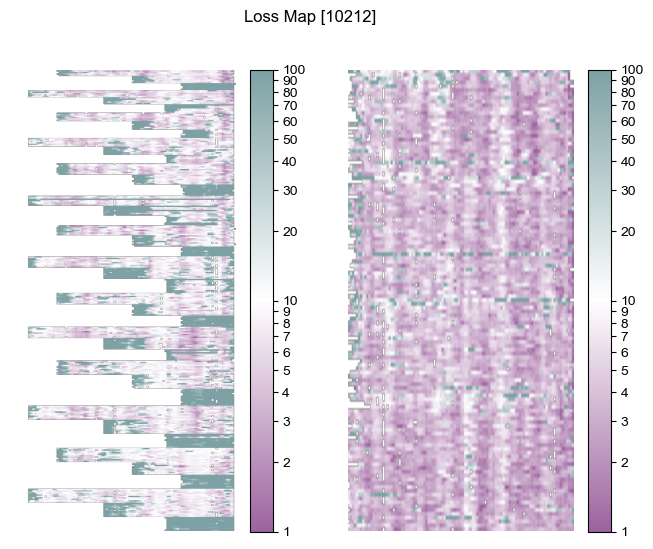

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:154: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:158: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.3930601578751993, p(x) = 0.07301506858339477


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:276: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


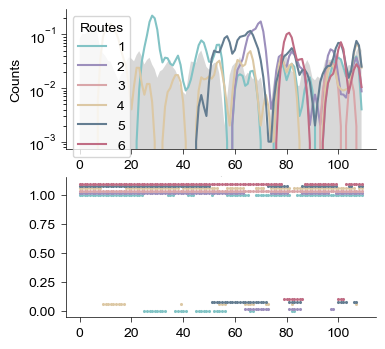

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:130: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


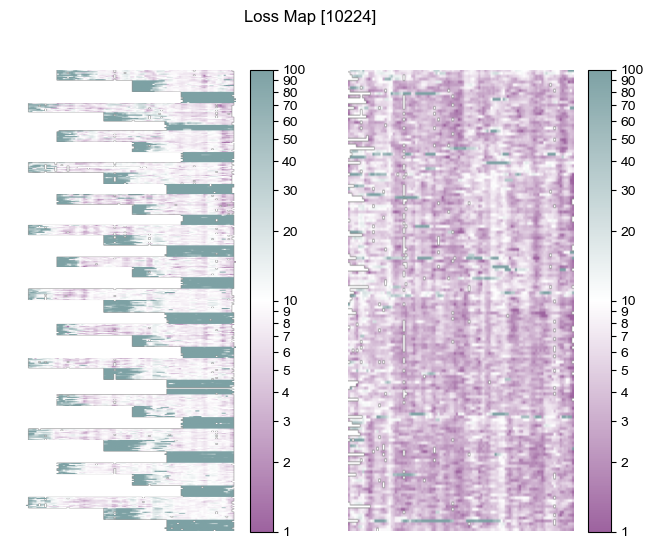

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:154: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:158: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.487697187696992, p(x) = 0.0306758828869394


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:276: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


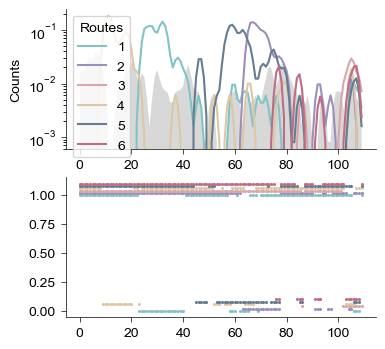

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:130: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


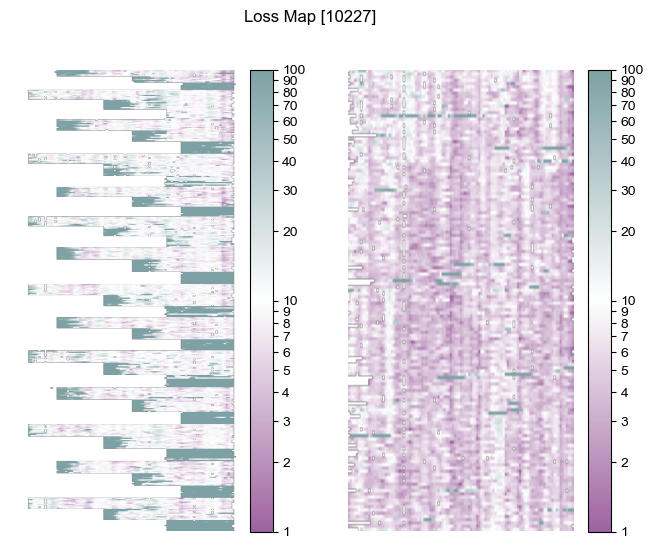

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:154: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:158: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.5478032350234538, p(x) = 0.030170551245208954


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:276: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


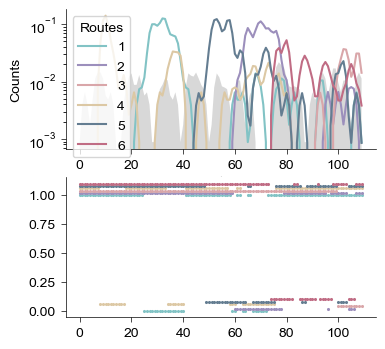

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:130: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


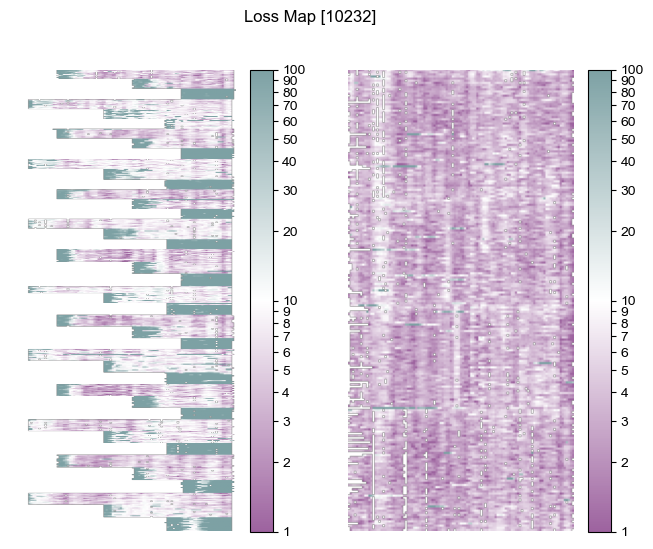

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:154: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:158: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.5179497829404396, p(x) = 0.030664901387758906


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\2856586125.py:276: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


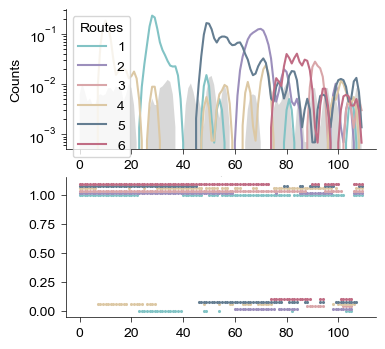

In [30]:
saved_dir_lossmap = join(loc, "Loss Maps")
mkdir(saved_dir_lossmap)

pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
if exists(join(saved_dir_lossmap, f" {10212} [Loss Map].pkl")) == False:
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
        
        session_traj = res['raw_session_traj']
        lap_traj = res['raw_lap_traj']
        route_traj = res['raw_route_traj']
        nodes_traj = res['raw_nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        time_traj = res['raw_time_traj']
        smoothed_loss_traj = res['raw_smoothed_loss_traj']
        speed_traj = res['raw_speed_traj']

        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse}:")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if rt in [0]:
                continue
            
            lmap = np.zeros(144, np.float64) * np.nan
            for j in range(beg[i], end[i]):
                if speed_traj[j] < 2.5:
                    continue
                lmap[father_nodes_traj[j]-1] = smoothed_loss_traj[j]
            loss_map.append(lmap)
            routes.append(rt)
        
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)
            
        with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'rb') as f:
            pretest_res = pickle.load(f)
            
        loss_traj = pretest_res['loss_traj']
        smoothed_loss_traj = pretest_res['smoothed_loss_traj']
        session_traj = pretest_res['session_traj']
        nodes_traj = pretest_res['nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        lap_traj = pretest_res['lap_traj']
        time_traj = pretest_res['time_traj']
        route_traj = np.repeat(0, len(lap_traj))
        
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse} (Pretest):")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if session_traj[beg[i]] <9:
                continue
            if rt in [0]:
                lmap = np.zeros(144, np.float64) * np.nan
                for j in range(beg[i], end[i]):
                    lmap[father_nodes_traj[j]-1] = smoothed_loss_traj[j]
                loss_map.append(lmap)
                routes.append(rt)
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)

from scipy.optimize import minimize_scalar

def gmm_pdf_scalar(x, weights, means, sigmas):
    # x is scalar
    val = 0.0
    for w, m, s in zip(weights, means, sigmas):
        val += w * (1.0 / (np.sqrt(2 * np.pi) * s)) * np.exp(-0.5 * ((x - m) / s)**2)
    return val
    
def find_gmm_saddle(weights, means, sigmas):
    """
    Find the local minimum of the 2-component GMM pdf between the two means.
    """
    # ensure sorted means
    order = np.argsort(means)
    means = means[order]
    sigmas = sigmas[order]
    weights = weights[order]

    # Minimize p(x) between the two component centers
    res = minimize_scalar(
        lambda z: gmm_pdf_scalar(z, weights, means, sigmas),
        bounds=(means[0], means[1]),
        method='bounded'
    )

    x_saddle = res.x
    y_saddle = gmm_pdf_scalar(x_saddle, weights, means, sigmas)
    return x_saddle, y_saddle

def fit_two_component_gmm(data):
    """
    data: 1D array-like of samples
    returns: fitted GaussianMixture instance
    """
    data = np.asarray(data).reshape(-1, 1)  # GMM expects 2D array

    gmm = GaussianMixture(
        n_components=2,
        covariance_type='full',   # fine for 1D
        random_state=0
    )
    gmm.fit(data)
    return gmm

for mouse in [10212, 10224, 10227, 10232]:
    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'rb') as f:
        loss_map, routes = pickle.load(f)

    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'rb') as f:
        loss_map_pretest, routes_pretest = pickle.load(f)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
    ax0 = Clear_Axes(axes[0])
    im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax0)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    ax1 = Clear_Axes(axes[1])
    im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    plt.suptitle(f"Loss Map [{mouse}]")
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].png"), dpi=600)
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].svg"), dpi=600)
    plt.show()
    """
    x = np.tile(np.arange(loss_map.shape[1]), (loss_map.shape[0], 1))
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x=x.flatten(),
        y=np.log10(loss_map).flatten(),
        
    )
    plt.show()
    """
    diff_map = np.diff(np.log10(loss_map), axis=1)
    x = np.tile(np.arange(loss_map.shape[1]-1), (loss_map.shape[0], 1))
    rts = np.tile(routes[:, np.newaxis], (1, loss_map.shape[1]-1))

    data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T
    x = x.flatten()
    rts = rts.flatten()
    
    idx = np.where(
        (np.isnan(data).sum(axis=1) == 0) &
        (np.isneginf(data).sum(axis=1) == 0)
    )[0]
    data = data[idx, :]
    x = x[idx]
    rts = rts[idx]
    from sklearn.mixture import GaussianMixture
    
    gmm = fit_two_component_gmm(data[:, 0])
    means = gmm.means_.flatten()        # shape (2,)
    covs = gmm.covariances_.flatten()   # shape (2,) for 1D
    weights = gmm.weights_.flatten()    # shape (2,)
    sigmas = np.sqrt(covs)

    # Sort components by mean so we know "left" and "right"
    order = np.argsort(means)
    means = means[order]
    sigmas = sigmas[order]
    weights = weights[order]
    
    x_saddle, y_saddle = find_gmm_saddle(weights, means, sigmas)
    print(f"Saddle point at x = {x_saddle}, p(x) = {y_saddle}")
    thre = 0.25
    
    data_pretest = np.vstack([
        np.log10(loss_map_pretest)[:, :-1].flatten(),
        np.diff(np.log10(loss_map_pretest), axis=1).flatten()
    ])
    x_pretest = np.tile(
        np.arange(loss_map_pretest.shape[1]-1),
        (loss_map_pretest.shape[0], 1)
    ).flatten()
    """
    plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.hist(data[:, 0], bins=250, density=True, alpha=0.5, color='gray', range=(0, 2.5))
    ax.axvline(x_saddle, color='red', lw=0.5, ls='--')
    ax.set_title(10**x_saddle)
    plt.show()
    
    plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.scatter(
        data[:, 0],
        data[:, 1],
        color='gray',
        s=1,
        alpha=0.5
    )
    
    ax.plot([0, 2.5], [x_saddle, x_saddle-2.5], color='k', lw=0.5, ls='--')
    ax.axvline(x_saddle, color='k', lw=0.5, ls='--')
    ax.plot([x_saddle-thre, x_saddle], [thre, thre], color='k', lw=0.5, ls='--')
    ax.plot([x_saddle, x_saddle+thre], [-thre, -thre], color='k', lw=0.5, ls='--')
    plt.show()
    """
    
    retrieval_points = np.where(
        (data[:, 0] > x_saddle) &
        #(data[:, 1] < -thre) &
        (data[:, 1] < x_saddle - data[:, 0])
    )[0]
    
    retrieval_points_pretest = np.where(
        (data_pretest[0, :] > x_saddle) &
        #(data_pretest[1, :] < -thre) &
        (data_pretest[1, :] < x_saddle - data_pretest[0, :])
    )[0]
    
    gkernel = np.exp(-0.5 * ((np.arange(-2, 3) / 1) ** 2))
    gkernel = gkernel / np.sum(gkernel)
    counts = np.zeros((6, 110), dtype=np.float64)
    n_laps = np.zeros(6, dtype=np.int64)
    for rt in range(1,7):
        rt_idx = np.where(rts[retrieval_points] == rt)[0]
        counts[rt-1, :] = np.histogram(x[retrieval_points][rt_idx], bins=110, range=(-0.5, 109.5))[0]
        counts[rt-1, :] = counts[rt-1, :] / np.where(routes == rt)[0].shape[0]
        n_laps[rt-1] = np.where(routes == rt)[0].shape[0]

        counts[rt-1, :] = np.convolve(counts[rt-1, :], gkernel, mode='same')
    
    n_shuf_selected = int(np.mean(n_laps))
    counts_shuf = np.zeros((10000, 110), dtype=np.float64)
    for shuf_i in range(10000):
        rand_idx = np.random.choice(loss_map_pretest.shape[0], n_shuf_selected, replace=False)
        data_pretest = np.vstack([
            np.log10(loss_map_pretest)[rand_idx, :-1].flatten(),
            np.diff(np.log10(loss_map_pretest)[rand_idx, :], axis=1).flatten()
        ])
        retrieval_points_shuf = np.where(
            (data_pretest[0, :] > x_saddle) &
            #(data_pretest[1, :] < -thre) &
            (data_pretest[1, :] < x_saddle - data_pretest[0, :])
        )[0]
        counts_shuf[shuf_i, :] = np.histogram(x_pretest[retrieval_points_shuf], bins=110, range=(-0.5, 109.5))[0]
        counts_shuf[shuf_i, :] = counts_shuf[shuf_i, :] / n_shuf_selected
        counts_shuf[shuf_i, :] = np.convolve(counts_shuf[shuf_i, :], gkernel, mode='same')
        
    counts_shuf_upper = np.percentile(counts_shuf, 95, axis=0)
    p_values = np.zeros((6, 110), dtype=np.float64)
    for rt in range(6):
        for pos in range(110):
            p_values[rt, pos] = np.sum(counts_shuf[:, pos] >= counts[rt, pos]) / 10000.0
    
    rts_all = np.tile(np.arange(1, 7)[:, np.newaxis], (1, 110))
    
    res = {
        "Routes": rts_all.flatten(),
        "Positions": np.tile(np.arange(110)[np.newaxis, :], (6, 1)).flatten(),
        "Counts": counts.flatten()
    }
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(4, 4))
    ax = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x="Positions",
        y="Counts",
        hue="Routes",
        palette=DSPPalette[1:],
        data=res,
        ax=ax
    )
    ax.fill_between(
        x=np.arange(110),
        y1=counts_shuf_upper,
        y2=0,
        color='gray',
        alpha=0.3,
        edgecolor=None
    )
    ax.semilogy()
    ax2 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    p_values[p_values < 1e-3] = 0
    p_values[p_values >= 1e-3] = 1
    for rt in range(6):
        ax2.scatter(
            np.arange(110),
            p_values[rt, :]+ 0.02 * rt,
            color=DSPPalette[rt+1],
            lw=0,
            s=5, 
            label=f"R{rt+1}"
        )
    plt.show()
    

# GNB Decoding on pretest data.

In [31]:
pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
def get_lapwise_nb_loss_pretest(mouse: int):
    if mouse in [10212]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 1')
        )[0]
        print(len(file_idx))
    elif mouse in [10224, 10227, 10232]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 2')
        )[0]
        print(len(file_idx))
    else:
        raise NotImplementedError(f"Mouse {mouse} not in the pretest group.")
    
    res = {
        "loss_traj": [],
        "smoothed_loss_traj": [],
        "session_traj": [],
        "nodes_traj": [],
        "time_traj": [],
        "lap_traj": [],
    }
    D = GetDMatrices(1, 48)
    for i in range(6, len(file_idx)):
        with open(f1['Trace File'][file_idx[i]], 'rb') as ff:
            trace = pickle.load(ff)
            
        print(f"{trace['MiceID']} ------ S{i+1} ------")
        print(DateTime())
        print(trace.keys())
            
        idx = np.where(
            np.isin(trace['ms_time'], trace['ms_time_behav'])
        )[0]
        
        assert idx.shape[0] == trace['ms_time_behav'].shape[0], "Mismatch in time indices."
        
        RawSpikes = np.where(
            trace['RawTraces'] - np.std(trace['RawTraces'], axis=1, keepdims=True)*3 >= 0, 1, 0
        )
        RawSpikes = RawSpikes[:, idx]
        spike_nodes = trace['spike_nodes_original'][idx].astype(np.int64)
        ms_time_behav = trace['ms_time_behav']
        
        
        lap_beg_time, lap_end_time = trace['lap beg time'], trace['lap end time']
        for j in range(len(lap_beg_time)):
            print(f"   Lap {j+1}:")
            train_idx = np.where(
                (ms_time_behav < lap_beg_time[j]) | 
                (ms_time_behav > lap_end_time[j])
            )[0]
            test_idx = np.where(
                (ms_time_behav >= lap_beg_time[j]) & 
                (ms_time_behav <= lap_end_time[j])
            )[0]
            
            model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
            model.fit(RawSpikes[:, train_idx], spike_nodes[train_idx])
            y_pred = model.predict(Spikes_test=RawSpikes[:, test_idx], MazeID_test=spike_nodes[test_idx]).astype(np.int64)
            y_test = spike_nodes[test_idx].astype(np.int64)
            loss_traj = D[(y_pred-1, y_test-1)]
            smoothed_loss_traj = np.convolve(loss_traj, np.ones(10)/10, mode='same')
            res['loss_traj'].append(loss_traj)
            res['smoothed_loss_traj'].append(smoothed_loss_traj)
            res['session_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * i)
            res['nodes_traj'].append(y_test)
            res['time_traj'].append(ms_time_behav[test_idx])
            res['lap_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * (j+1))
            
    for key in res.keys():
        res[key] = np.concatenate(res[key])
        
    with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'wb') as f:
        pickle.dump(res, f)
    
    print(DateTime())
    print("Saved ---------", end="\n\n\n")
    
#get_lapwise_nb_loss_pretest(10212)
#get_lapwise_nb_loss_pretest(10224)
#get_lapwise_nb_loss_pretest(10227)
#get_lapwise_nb_loss_pretest(10232)

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!


# Map Cluster for each bin